<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">22.418 · Aprenentatge automàtic</p>
<p style="margin: 0; text-align:right;">Grau en Ciència de Dades Aplicada</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Reinforcement learning 1: the maze


## Introduction 

This example shows a complete reinforcement learning (RL) example using "classical" Q-learning, with a table of states/actions that gets filled as the agent trains, and with all the RL aspects directly programmed here.

The environment used is a rather simple one, a maze where the player has to find its way from the start (blue square) to the end (red square).

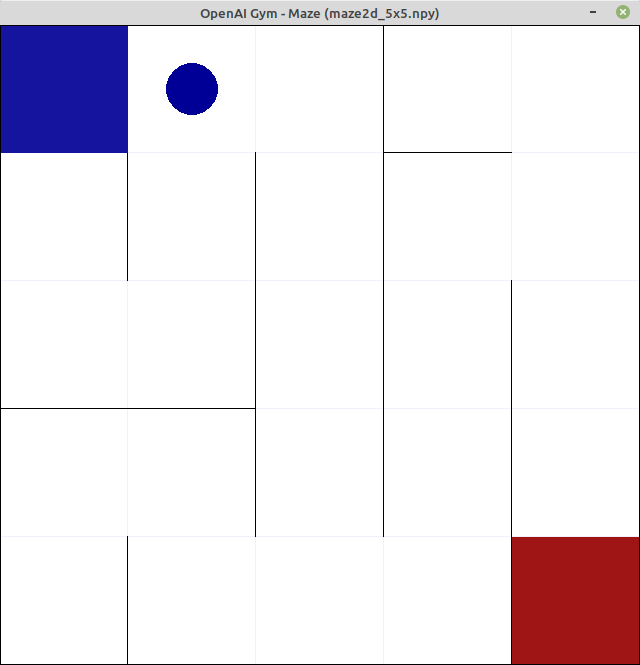

Source: [https://github.com/MattChanTK/gym-maze](https://github.com/MattChanTK/gym-maze)

It is integrated into [OpenAI Gym](https://gym.openai.com/), which is a framework for RL with many different environments. It has become one of the main references for RL learning and research. One of its advantages is that all the environments, regardless of their specific features, share a common interface, that can be summarized in the following steps:

1. Create the environment
2. Get the current state of the environment, or more precisely the observation of the environment, what the agent can perceive
3. The agent decides its next action and executes it on the environment
4. The agent gets a reward
5. Go back to point 2 until the end of the episode or other custom condition


## Setting up the environment

As this Maze project is not included with OpenAI Gym, it has to be installed, which simply requires to extract the provided ```gym_maze.zip``` file to the current directory.

Besides, some standard Python packages have to be installed using ```pip```.


Once installed Maze integrates into OpenAI Gym, so if the installation is successful you will be able to create the Maze environment and test your RL algorithms on it.

***

*Note*: Jupyter and PyGame do not interact perfectly, so it is possible that you will have to rerun some cells because the previous PyGame window has not closed completely.

## Exploring the environment
Before delving into RL itself, let us just try the Maze environment so that we get familiar with the Gym API, running the environment and rendering it. 

First, the desired environment is created, here a 5x5 maze with a fixed layout (other mazes are randomly generated on each episode). 

Second, the environment is reset to take it to the initial state, with the player at the blue square. 

Third, the environment is rendered (if RENDER==True) so we can see it on screen. As it uses [PyGame](https://www.pygame.org/), it will show in a new window. By default rendering is disabled, as it is not supported directly in Google Colab.

In [1]:
!pip install numpy gym pygame
!unzip gym_maze.zip

     |████████████████████████████████| 11.8MB 5.6MB/s 
Archive:  gym_maze.zip
   creating: gym_maze/
  inflating: gym_maze/__init__.py    
   creating: gym_maze/envs/
  inflating: gym_maze/envs/__init__.py  
  inflating: gym_maze/envs/maze_env.py  
  inflating: gym_maze/envs/maze_generator.py  
   creating: gym_maze/envs/maze_samples/
  inflating: gym_maze/envs/maze_samples/maze2d_100x100.npy  
  inflating: gym_maze/envs/maze_samples/maze2d_10x10.npy  
  inflating: gym_maze/envs/maze_samples/maze2d_3x3.npy  
  inflating: gym_maze/envs/maze_samples/maze2d_5x5.npy  
  inflating: gym_maze/envs/maze_view_2d.py  


In [2]:
import gym_maze
import gym
import pygame

RENDER = False

env = gym.make('maze-sample-5x5-v0', enable_render=RENDER)

obs = env.reset()

if RENDER:
  env.render()
;

pygame 2.0.1 (SDL 2.0.14, Python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


''

*Note*: the semicolon (;) at the end of the previous cell prevents Jupyter from printing the result of ```env.render()```, which is an array with all the cells of the maze.

Before we run the game, let us check some very important elements: the **observation space** and the **action space**.

The **observation space** is what the agent receives from the environment on each iteration, and its format can be easily obtained in Gym:

In [3]:
env.observation_space

Box(0, 4, (2,), int64)

Which means that the observation space is a 2D box (like an array) with indices from 0 to 4 on both axes. This gives a total of 5*5 = 25 states, a tiny number compared to most RL environments, and the main reason why we begin with this example. 

If we check the result from the ```env.reset()``` instruction we can check the specific value for the observation after resetting the environment:

In [4]:
obs

array([0., 0.])

Which means that the current position of the agent is 0, 0, i.e. the top-left corner. This is the only information needed to define the state of this environment, as nothing else can change here. 

On the other hand, the **action space** is the set of actions the agent can choose from, and it can be checked with:

In [5]:
env.action_space

Discrete(4)

Which means that the action space is *discrete* (actions are on/off, differently from *continous* actions such as the torque of a motor, that can be a number inside a range), and there are four actions, that correspond with the agent moving in one of the four directions. 

The ```step()``` method executes one step of the RL loop. It receives the action to be executed by the agent, then returns four values, consequence of the action chosen: the observation of the new state of the environment, the reward obtained, a boolean ```done``` that is ```True``` when the episode finishes (for example the agent reaches the goal) and a fourth value with debugging information (that should not be used in competitions).

Here we can see an example of ```step()``` and the results obtained:

In [6]:
obs, rwd, done, info = env.step(2)

if RENDER:
  _ = env.render()

print(obs)
print(rwd)
print(done)

[1 0]
-0.004
False


Where the agent has chosen action 2 (move right), so environment has changed its state.

Exploring the four possible actions you can find out their meaning: 0=up, 1=down, 2=right, 3=left. This encoding depends on the specific environment, and you should check its documentation or play with it to find them out. However, for RL the exact encoding of actions is not really important, as we are not going to use them explicitly.

You can also see the new observation (new position of the agent), the reward obtained (there is a penalty for each step, the only positive reward comes from reaching the goal), and finally ```done==False``` which means that the episode has not ended yet.

Finally, for clean operation the environment must be closed:

In [7]:
env.close()
pygame.quit()

## First run

Before we add RL to this environment, let us do a very simple run, with randomly picked actions for 200 steps, so we can see the environment in action and most of what will be the RL loop.

Method ```sample()``` picks a random value from the action space.

In [8]:
import gym 
import gym_maze

env = gym.make('maze-sample-5x5-v0', enable_render = RENDER)

env.reset()

for step in range(200):
    if RENDER:
      env.render()
    env.step(env.action_space.sample())
env.close()
pygame.quit()

As you have seen, the agent moves around randomly (and most likely it will not reach the goal).

**Note**: you may have to restart Jupyter's kernel because sometimes the PyGame window does not close properly.

# RL with Q-learning
Now that you know how to use the environment, it is time to use Q-learning so that the agent learns how to get to the goal in this maze. The basic Q-learning includes a table of states x actions (so 25 x 4), where it will slowly store the estimated reward of choosing action *a* in state *s*. With some probability *epsilon* the agent will choose a random action instead of the best one, in order to encourage exploration.

First we will define the required functions and data for Q-learning, then the RL loop itself in the Maze environment.

## Supporting functions

### Create the Q-table
Given an environment, the Q-table must be of size states x actions. ```env.observation_space.high``` gives the highest indices of the observation space, and with that we can determine the number of states. The ```n``` attribute is the number of actions in the action space.

Initially all the expected rewards are zero.

*Note*: ```+ 1``` is needed as this is Python, so if the last index is 4 then there are 5 elements.

In [9]:
import numpy

def create_q_table(env):
    rows, cols = env.observation_space.high + 1
    actions    = env.action_space.n
    
    return numpy.zeros((rows * cols, actions))

In [10]:
q_table = create_q_table(env)
q_table.shape

(25, 4)

### Observations to Q-table
When we translate multidimensional value to a single index in order to fit it in a matrix, such as it happens here from the x,y position of the agent to a row number in the Q-table, we usually talk about these positions in the 1D index as **buckets**. Here we have to translate the x, y position of the agent to a row number in the Q-table, so our function will be called ```obs_to_bucket``` for that reason. 

*Note*: ```env.observation_space.high == [4, 4]```, as they are the highest possible values for the row/column indices. In turn, that means that there are 5x5 cells, that is why the ```+ 1``` is needed to correctly translate from row/column to a single index.

In [11]:
def obs_to_bucket(env, obs):
    row, col = obs
    return int(row*(env.observation_space.high[1] + 1) + col)

# Example calls
print(obs_to_bucket(env, [0, 2]))
print(obs_to_bucket(env, [2, 0]))
print(obs_to_bucket(env, [2, 2]))

2
10
12


### Select action
Q-learning chooses a random action with probability epsilon or the best action (highest value in the Q-table) otherwise. 

In [12]:
import random

def choose_action(env, q_table, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        return int(numpy.argmax(q_table[state]))

### Update Q-table
After an action is executed, the agent receives the new state (observation) and a reward. It is time to update the Q-table, considering which was the previous state, the action chosen, the reward obtained and the new state. This function performs this update, considering also the learning rate and the discount factor (future rewards are not as worthy as immediate ones). 

In [13]:
def update_q_table(q_table, prev_state, new_state, action, reward, learning_rate, discount):
    # The best expected reward in the new state
    best_exp_rwd = numpy.amax(q_table[new_state])
    
    # Expected reward of the previous state and action
    prev_exp_rwd = q_table[(prev_state, action)]
    
    q_table[prev_state, action] += learning_rate * (reward + discount*best_exp_rwd - prev_exp_rwd)

## The RL loop
After setting up all the required auxiliary functions, the actual training of the agent using RL can start. After the initialization of the environment and other data structures, the training is a loop with the following steps:

1. Get the observation from the environment (to infer the current state)
2. Choose the best action for the current state given the expected rewards in the Q-table *or* choose a random action with probability *epsilon*
3. Execute the action
4. Retrieve the new observation and the reward for the action just executed
5. Update the Q-table accordingly, considering: the previous state, the action chosen, the reward obtained and the new state the action has taken the environment to

The next function executes the RL loop for a number of episodes (games).

In [14]:
def rl_loop(env, num_episodes, max_steps, learning_rate, epsilon, discount):
    
    q_table = create_q_table(env)
    
    episode_total_rewards = []
    
    for episode in range(num_episodes):
        
        # We want a fresh maze on each new episode
        # env.reset() returns the observation of the initial state
        obs = env.reset()
        
        # Convert observation to state
        curr_state = obs_to_bucket(env, obs)
        
        # Reward of the current episode
        episode_reward = 0.0
        
        for step in range(max_steps):
            
            # Choose action and execute it
            action = choose_action(env, q_table, curr_state, epsilon)
            
            obs, reward, done, info = env.step(action)
            
            # Move on to current state
            prev_state = curr_state
            curr_state = obs_to_bucket(env, obs)
            
            episode_reward += reward
            
            update_q_table(q_table, prev_state, curr_state, action, reward, learning_rate, discount)
            
            # Render the environment so we can see the result
            if RENDER:
              env.render()
            
            # Check if the episode ends (goal reached)
            if done:
                break
                
        # When the episode ends, do some updates
        episode_total_rewards.append(episode_reward)
        
        epsilon = max(0.1, epsilon*0.95)
    
    return q_table, episode_total_rewards

Finally it is time to start the environment and run the RL training algorithm, which is very simple as you can see here. The most important thing when calling ```rl_loop``` are the hyperparameters of Q-learning:
- ```num_episodes```: number of episodes the RL agent is going to be executed. Here each episode lasts until either the agent reaches the goal, or it reaches amaximum number of steps (see next parameter)
- ```max_steps```: if the agent does not reach the goal in this number of steps or less, the episode fails, basically meaning that the agent does not get the only positive reward, given when it reaches the goal. It is important to avoid the agent running randomly forever. The exact value depends on the complexity of the task, more complex tasks require extra steps for the agent to have a chance of finding the goal, at least at the beginning of the training
- ```learning_rate```: this value controls how the current reward modifies the existing expected reward in the q-table. A value of 1 would simply forget the previous values, while a value of 0 would never update the q-table
- ```epsilon```: the chance of randomly choosing an action instead of choosing the action with maximum expected reward. This parameter influeces the exploration vs exploitation aspect.  *epsilon* is usually high during the first episodes (exploration), and gradually decreases as the agent learns (explotation of acquired knowledge)
- ```discount```: future rewards are not as worthy as immediate ones. The discount factor models this, as it multiply future rewards, actually decreasing their importance. It is usually a value between 0.95 and 0.99, and the exact value depends on how distant in the future the rewards are expected to be


In [15]:
import gym 
import gym_maze

env = gym.make('maze-sample-5x5-v0', enable_render=RENDER)

q_table, rewards = rl_loop(env, num_episodes=100, max_steps=50, learning_rate=0.8, epsilon=0.8, discount=0.99)

env.close()
pygame.quit()

# Analysis of the results

You have seen on the game window how the agent learns the path to the goal more and more efficiently as it trains. Let us have a look at some of the internal results of the RL process in order to better understand what has happened there.

## Q-table
The q_table is like the memory of the agent, it tells what is the expected reward at state *i* (row) if it takes action *j* (column).
For example, at state 0, which corresponds to cell 0,0, the best reward is for going right, so this will be the default action unless *epsilon* makes it choose a random action. At state 23, right above the goal, the best action is going south (a full 1.0 reward). The goal itself is state 24, where the episode ends and consequently no rewards are recorded.

In [16]:
import pandas as pd
df = pd.DataFrame(q_table)
df.columns = ['UP', 'DOWN', 'RIGHT', 'LEFT']
df

,UP,DOWN,RIGHT,LEFT
0,0.781761,0.814863,0.828529,0.814708
1,-0.042280,-0.044796,-0.041186,-0.042487
2,-0.044088,-0.044804,-0.047115,-0.044591
3,-0.025894,-0.026410,-0.029672,-0.025616
4,-0.027945,-0.029421,-0.028975,-0.027895
5,0.116555,-0.047307,0.840939,0.781747
6,0.653764,-0.045573,-0.047318,-0.047354
7,-0.045040,-0.045888,-0.046671,-0.046569
8,-0.027340,-0.028839,-0.027875,-0.028706
9,-0.029514,-0.028496,-0.027474,-0.029322


## Rewards 

The most important tool to understand the learning process in RL is to monitor the reward obtained on each episode, where we would expect to see a rising curve that gradually stabilizes. Let us verify that.

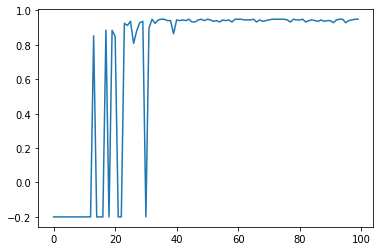

In [17]:
import matplotlib.pyplot as plt

plt.plot(rewards)

As you can see here, in the first episodes the agent does not reach the goal, so it gets a negative reward (it only gets positive rewards for reaching the goal). In some episodes, it reaches the goal but with a lot of steps, so the reward is around 0.8. From episode 25 on, it systematically reaches the goal in a very efficient way, but for one episode where it fails to reach it, most likely due to a chain of wrong random actions chosen.

The conclusion here is that the RL loop needed around 40 episodes to train a proficient agent. Further training does not lead to significant improvements.

## Activities

The previous example has shown how to create and train a Q-learning agent, using a Q-table to store the expected rewards for each (state, action) pair. Here we propose some questions or experiments to get more insight into the Q-learning algorithm.

### Questions
*   The state of the environment is given simply by the position of the agent. How would it change if there was a cell with a hole (fixed position), so that if the agent falls in it dies and gets a negative reward? How much would the number of possible states grow? What else would you have to change?
*   Now imagine that there is an enemy wandering around. How does this affect the states of the game? 

### Experiments
*   Add one or more "holes" to the maze, so that if the agent falls in it dies and gets negative reward. You can check for the holes inside the RL loop, and give rewards/end episode accordingly.
*   Study the influence of the *epsilon* parameter. First, plot the values of *epsilon* as it decays. Then try different decay curves (change decay factor or minimum *epsilon*) and analyze the results. Can you improve the learning process this way?
